In [ ]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/Colab Notebooks/Data/cat-dog-dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/Data"

Global path declaration

In [ ]:
cat_train_path = r"/content/drive/MyDrive/final_dataset/train/cat"

cat_test_path = r"/content/drive/MyDrive/final_dataset/test/cat"

dog_train_path = r"/content/drive/MyDrive/final_dataset/train/dog"

dog_test_path = r"/content/drive/MyDrive/final_dataset/test/dog"

train_path = r"/content/drive/MyDrive/final_dataset/train"

test_path = r"/content/drive/MyDrive/final_dataset/test"

In [ ]:
import os

for files in os.listdir(cat_test_path):
  print(files)

6XYR4F6ZKSEH.jpg
C76ZX8TMOVVA.jpg
9DCGHZ8GDNPO.jpg
MURRTROT8AUA.jpg
HP1D5WQU7R3Z.jpg
AJFVPN8435DE.jpg
V81FTI061R3X.jpg
7K7DKQV65U8Z.jpg
DYSBXN7Q1GYO.jpg
ENOHUZGJJNJX.jpg
LV94XP21ZDS6.jpg
OBZ4VXYZSS2X.jpg
5CZK154GZS7F.jpg
3LQR8QDV9F7O.jpg
K2TRD9QMTOBX.jpg
KMZDY14YCGGX.jpg
QOX0SHHKJNOI.jpg
CUMLEKYE2P14.jpg
BO59UQLWM38C.jpg
UZRU4GAAPDYF.jpg
LFWS96UI1Y83.jpg
KKK16H989RAK.jpg
GAK11D2Z9SPM.jpg
QKZV6MBJ0YZM.jpg
KDGV8YEW5DH9.jpg
LIGTIIBMIN45.jpg
YQVNFICVGTHY.jpg
C9V1XMBH0VWL.jpg
0RMV25H0AQ6R.jpg
HY1H8631IT4Y.jpg
OSMN3GJRZE6R.jpg
R60JQKIXG6PR.jpg
WI5GBB4LREIZ.jpg
Q3XZZ52PZW3V.jpg
IFWUTYU67PJF.jpg
AVBLPRZWQOLI.jpg
EETRLCCWZ6QF.jpg
5EKZRP9P7TFF.jpg
W80IAA2G00WA.jpg
E8NMBKX11LAU.jpg
KJHBW42CLNRB.jpg
GZXBI5DNXX7U.jpg
HYJ7KKBTEDM8.jpg
5RPC9I1U3S2G.jpg
S72FMORCAO9S.jpg
PGXNB2GVY5XM.jpg
TXB275WJC1FN.jpg
6VR3KF6VTAH6.jpg
3BA3JXAB07B5.jpg
QBUL7803J60V.jpg
02W0NM8M7GKX.jpg
N47GGWQWS5GC.jpg
UGKTV1FXA68M.jpg
4J3DNMK4JFU2.jpg
PDE77I72GFYO.jpg
0ZL6SJ9SVESD.jpg
JRNSK5QETMEM.jpg
TIZT0M7UMLSP.jpg
9NC2NSZS38HM.j

Data preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image, UnidentifiedImageError

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Data preparation
IMG_SIZE = 32 #32x32 pixel
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #resize image
    transforms.ToTensor(), #convert image to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) #normalize pixel from -1 to 1
])

class FilteredImageFolder(Dataset):
    def __init__(self, root, max_samples_per_class, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._filter_images(max_samples_per_class)

    def _filter_images(self, max_samples_per_class):
      samples = []
      class_counts = {}

      for class_idx, class_name in enumerate(sorted(os.listdir(self.root))):
          class_folder = os.path.join(self.root, class_name)

          if os.path.isdir(class_folder):

              class_counts[class_name] = 0

              for filename in os.listdir(class_folder):

                  if class_counts[class_name] >= max_samples_per_class:
                    break

                  filepath = os.path.join(class_folder, filename)
                  try:
                      with Image.open(filepath) as img:
                          #img.verify()

                          img = img.convert("RGB")
                          img.load()

                      samples.append((filepath, class_idx))
                      class_counts[class_name] += 1
                      print(class_counts)
                      #if count >= max_samples_per_class:
                        #return samples

                  except UnidentifiedImageError:
                      print(f"UnidentifiedImageError: Skipping file {filepath}")
                  except IOError:
                      print(f"IOError: Skipping file {filepath}")
                  except Exception as e:
                      print(f"Unexpected error {e}: Skipping file {filepath}")
      return samples

    def __len__(self):
        return len(self.samples)

    #updated version
    def __getitem__(self, idx):
      filepath, label = self.samples[idx]
      try:
          with Image.open(filepath) as img:
              img = img.convert("RGB")  # Ensure it's a 3-channel image
              if self.transform:
                  img = self.transform(img)
          return img, label
      except Exception as e:
          print(f"Error loading {filepath}: {e}")
          # Return a dummy tensor and an invalid label (-1), or retry another index
          return torch.zeros(3, IMG_SIZE, IMG_SIZE), -1

# Initialize datasets with filtered images
train_dataset = FilteredImageFolder(train_path, 750, transform=transform)
test_dataset = FilteredImageFolder(test_path, 250, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# # Resnet Model initialization
# model = models.resnet18(pretrained=True)
# model.to(device)

# # Load the model if it exists
# model_path = 'model.pth'
# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path))
#     model.eval()
#     print("Model loaded successfully.")
# else:
#     # Train model if not already trained
#     print("Training the model...")

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#     for epoch in range(5):
#         model.train()
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     # Save the trained model
#     torch.save(model.state_dict(), model_path)
#     print("Model saved successfully.")

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(train_dataset.samples)  # Print samples to verify

Using device: cpu
{'cat': 1}
{'cat': 2}
{'cat': 3}
{'cat': 4}
{'cat': 5}
{'cat': 6}
UnidentifiedImageError: Skipping file /content/drive/MyDrive/final_dataset/train/cat/KQKKOACXTE7Q.jpg
{'cat': 7}
{'cat': 8}
{'cat': 9}
{'cat': 10}
{'cat': 11}
UnidentifiedImageError: Skipping file /content/drive/MyDrive/final_dataset/train/cat/O615F2M35ET1.jpg
{'cat': 12}
{'cat': 13}
{'cat': 14}
{'cat': 15}
{'cat': 16}
{'cat': 17}
{'cat': 18}
{'cat': 19}
{'cat': 20}
UnidentifiedImageError: Skipping file /content/drive/MyDrive/final_dataset/train/cat/JMFBQKPANG4O.jpg
{'cat': 21}
{'cat': 22}
{'cat': 23}
{'cat': 24}
{'cat': 25}
{'cat': 26}
{'cat': 27}
{'cat': 28}
{'cat': 29}
{'cat': 30}
{'cat': 31}
{'cat': 32}
{'cat': 33}
{'cat': 34}
{'cat': 35}
{'cat': 36}
{'cat': 37}
{'cat': 38}
{'cat': 39}
{'cat': 40}
{'cat': 41}
{'cat': 42}
{'cat': 43}
{'cat': 44}
{'cat': 45}
{'cat': 46}
{'cat': 47}
{'cat': 48}
{'cat': 49}
{'cat': 50}
{'cat': 51}
{'cat': 52}
{'cat': 53}
{'cat': 54}
{'cat': 55}
{'cat': 56}
{'cat': 57}
{

In [ ]:
print(test_dataset.samples)

[('/content/drive/MyDrive/final_dataset/test/cat/6XYR4F6ZKSEH.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/C76ZX8TMOVVA.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/9DCGHZ8GDNPO.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/MURRTROT8AUA.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/HP1D5WQU7R3Z.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/AJFVPN8435DE.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/V81FTI061R3X.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/7K7DKQV65U8Z.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/DYSBXN7Q1GYO.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/ENOHUZGJJNJX.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/LV94XP21ZDS6.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/OBZ4VXYZSS2X.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/5CZK154GZS7F.jpg', 0), ('/content/drive/MyDrive/final_dataset/test/cat/3LQR8QDV9F7O.jpg', 0), ('/co

EDA

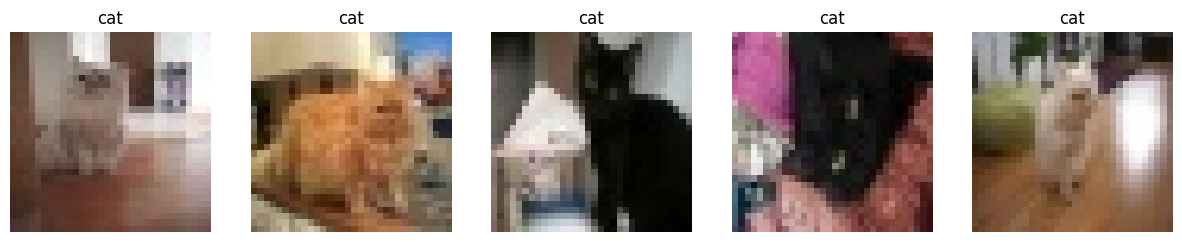

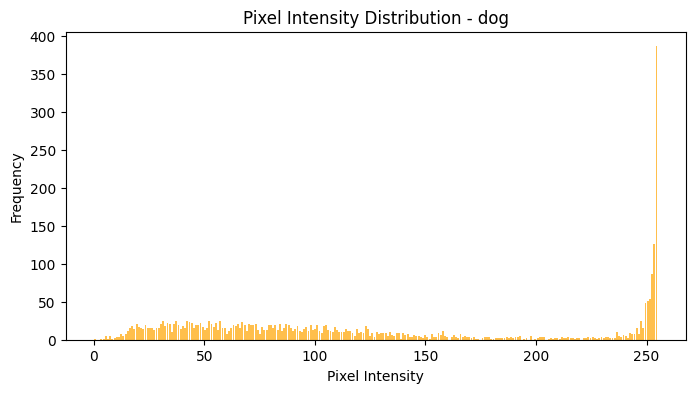

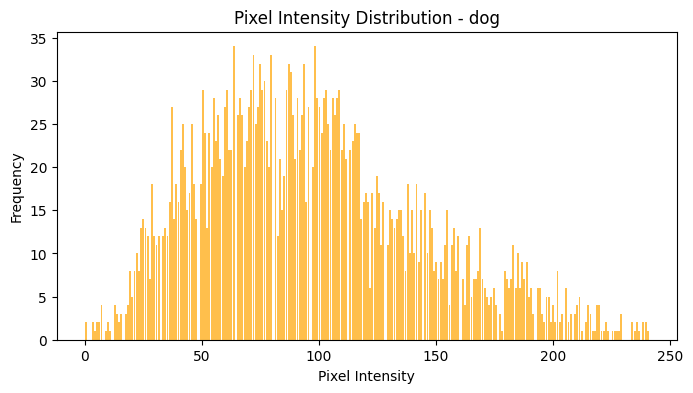

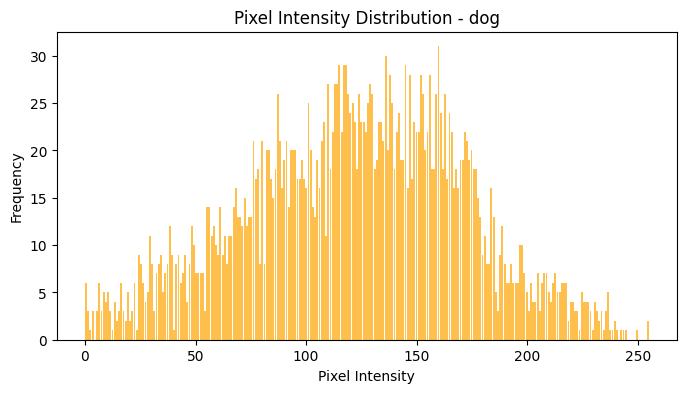

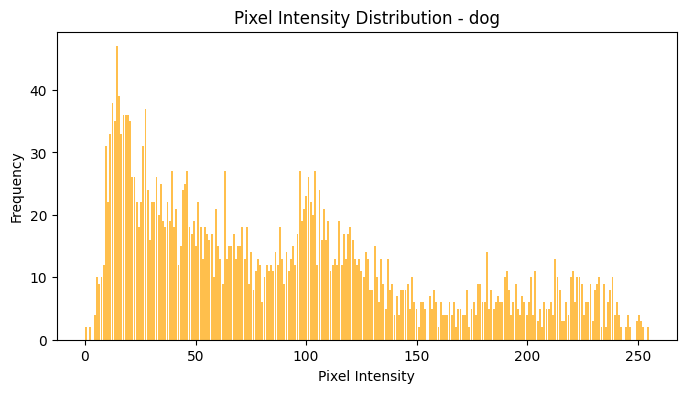

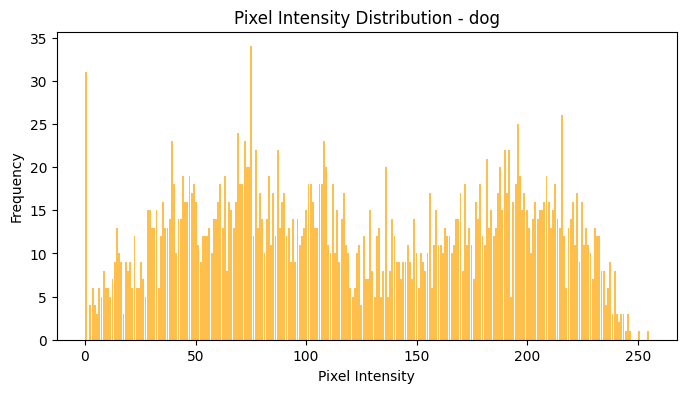

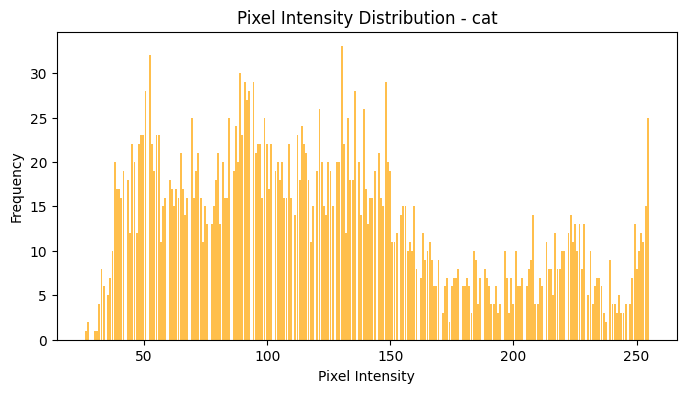

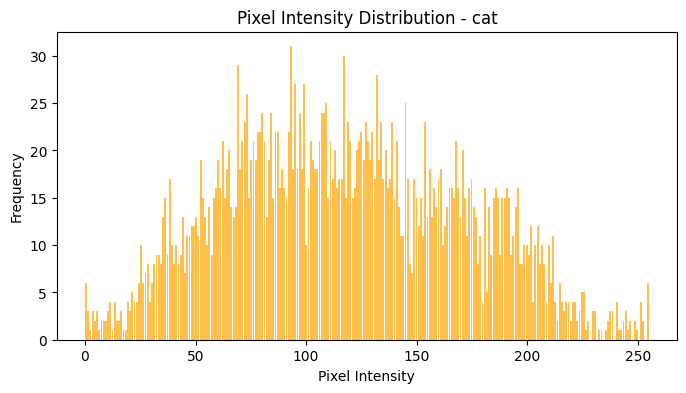

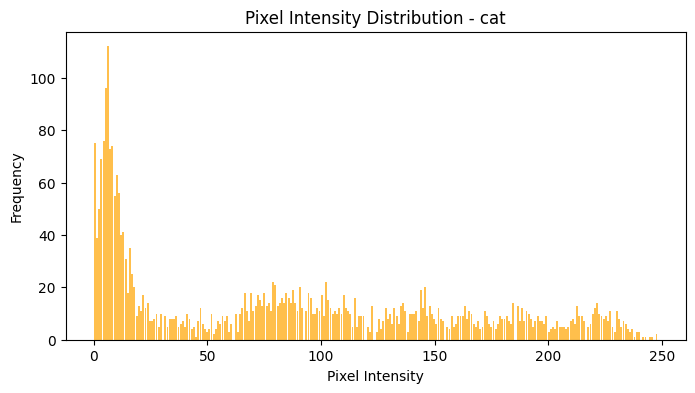

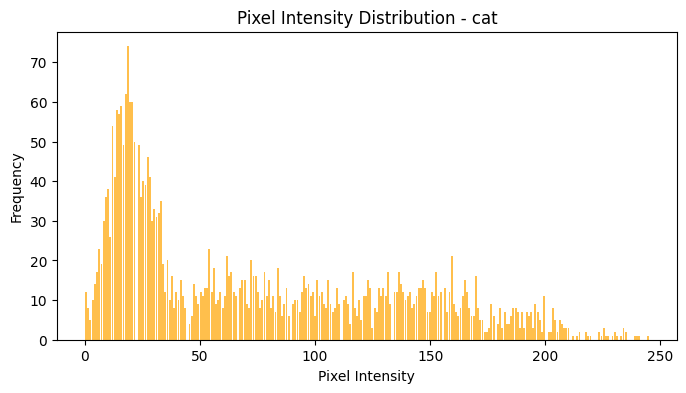

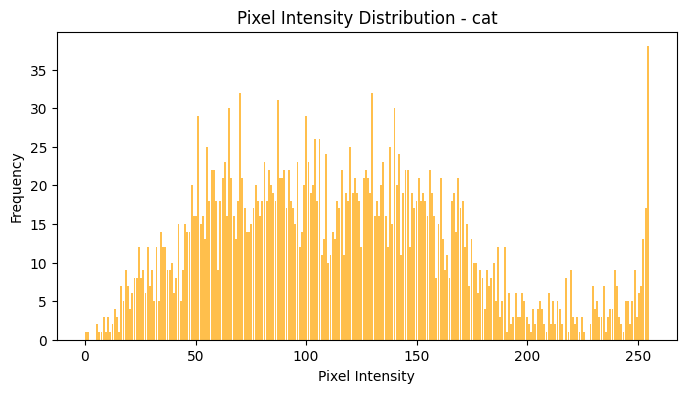

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def visualize_sample_images(image_folder, num_samples=5):
    class_names = os.listdir(image_folder)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(image_folder, class_name)
        sample_files = os.listdir(class_folder)[:num_samples]
        for j, file in enumerate(sample_files):
            img_path = os.path.join(class_folder, file)
            img = Image.open(img_path)
            axes[j].imshow(img)
            axes[j].set_title(class_name)
            axes[j].axis('off')
    plt.show()

def plot_image_histogram(image_folder, num_samples=5):
    class_names = os.listdir(image_folder)
    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        sample_files = os.listdir(class_folder)[:num_samples]
        for file in sample_files:
            img_path = os.path.join(class_folder, file)
            img = Image.open(img_path)
            img_array = np.array(img)
            plt.figure(figsize=(8, 4))
            plt.hist(img_array.ravel(), bins=256, color='orange', alpha=0.7, rwidth=0.85)
            plt.title(f'Pixel Intensity Distribution - {class_name}')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')
            plt.show()


visualize_sample_images(train_path)
plot_image_histogram(train_path)

Training the cnn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# 1. Data preparation with augmentation
IMG_SIZE = 32
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

class FilteredImageFolder(Dataset):
    def __init__(self, root, max_samples_per_class, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._filter_images(max_samples_per_class)

    def _filter_images(self, max_samples_per_class):
        samples = []
        class_counts = {}

        for class_idx, class_name in enumerate(sorted(os.listdir(self.root))):
            class_folder = os.path.join(self.root, class_name)
            if os.path.isdir(class_folder):
                class_counts[class_name] = 0
                for filename in os.listdir(class_folder):
                    if class_counts[class_name] >= max_samples_per_class:
                        break
                    filepath = os.path.join(class_folder, filename)
                    try:
                        with Image.open(filepath) as img:
                            img = img.convert("RGB")
                            img.load()
                        samples.append((filepath, class_idx))
                        class_counts[class_name] += 1
                    except Exception as e:
                        print(f"Skipping file {filepath}: {e}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filepath, label = self.samples[idx]
        try:
            with Image.open(filepath) as img:
                img = img.convert("RGB")
                if self.transform:
                    img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), -1

# Initialize datasets with augmented images
train_dataset = FilteredImageFolder(train_path, 750, transform=transform)
test_dataset = FilteredImageFolder(test_path, 250, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 2. Define a CNN with Dropout
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), #32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), #16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), #8x8
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128), #output 4x4
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CatDogCNN().to(device)

# 3. Loss and optimizer with weight decay
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # Adam optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # sgd optimizer - 68
optimizer = optim.RMSprop(model.parameters(), lr=0.001) #rmsprop - 73/71.2
# optimizer = optim.AdamW(model.parameters(), lr=0.001) #adamw - 70/68

# 4. Train the model
EPOCHS = 20
best_val_loss = float('inf')
early_stop_count = 0
early_stop_patience = 3  # Stop if validation loss doesn't improve for 3 epochs

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Evaluate on validation set for early stopping
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Final evaluation on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")

Skipping file /content/drive/MyDrive/final_dataset/train/cat/KQKKOACXTE7Q.jpg: cannot identify image file '/content/drive/MyDrive/final_dataset/train/cat/KQKKOACXTE7Q.jpg'
Skipping file /content/drive/MyDrive/final_dataset/train/cat/O615F2M35ET1.jpg: cannot identify image file '/content/drive/MyDrive/final_dataset/train/cat/O615F2M35ET1.jpg'
Skipping file /content/drive/MyDrive/final_dataset/train/cat/JMFBQKPANG4O.jpg: cannot identify image file '/content/drive/MyDrive/final_dataset/train/cat/JMFBQKPANG4O.jpg'
Skipping file /content/drive/MyDrive/final_dataset/train/cat/7G5H1ZZ8FY6N.jpg: cannot identify image file '/content/drive/MyDrive/final_dataset/train/cat/7G5H1ZZ8FY6N.jpg'
Skipping file /content/drive/MyDrive/final_dataset/train/cat/DMQEGXH4F0UL.jpg: cannot identify image file '/content/drive/MyDrive/final_dataset/train/cat/DMQEGXH4F0UL.jpg'
Skipping file /content/drive/MyDrive/final_dataset/train/cat/NIVH7TR23N3T.jpg: cannot identify image file '/content/drive/MyDrive/final_data

Evaluation metric and visualization

Accuracy: 68.40%
Precision: 0.70
Recall: 0.64
F1 Score: 0.67
AUC: 0.74


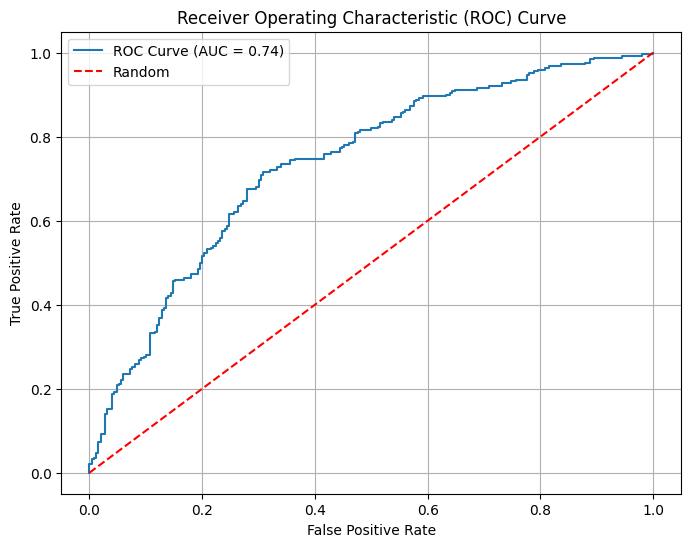

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

# Function to calculate precision, recall, F1 score, and AUC
def calculate_metrics(true_labels, predicted_labels):
    true_positive = np.sum((true_labels == 1) & (predicted_labels == 1))
    false_positive = np.sum((true_labels == 0) & (predicted_labels == 1))
    false_negative = np.sum((true_labels == 1) & (predicted_labels == 0))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate on the entire test set for more stable metrics
all_labels = []
all_preds = []
all_outputs = []  # Collect raw outputs for AUC calculation
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds.extend(preds.cpu().numpy().flatten())
        all_outputs.extend(outputs.cpu().numpy().flatten())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_preds))
    auc = roc_auc_score(np.array(all_labels), np.array(all_outputs))

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC: {auc:.2f}')

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(np.array(all_labels), np.array(all_outputs))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

feature maps

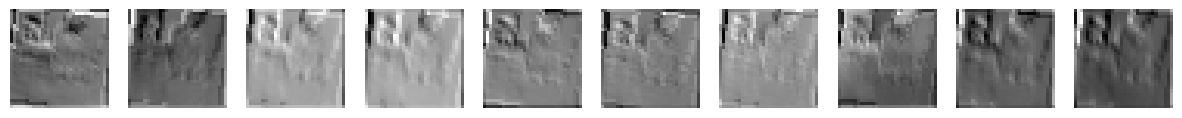

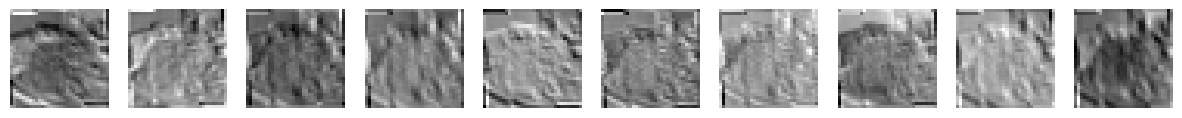

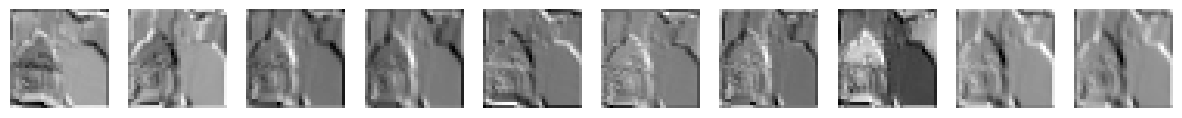

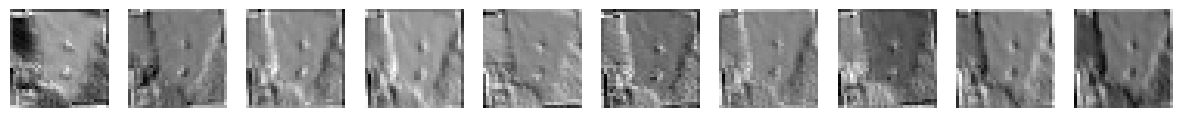

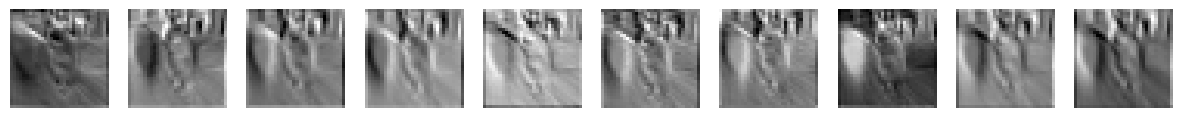

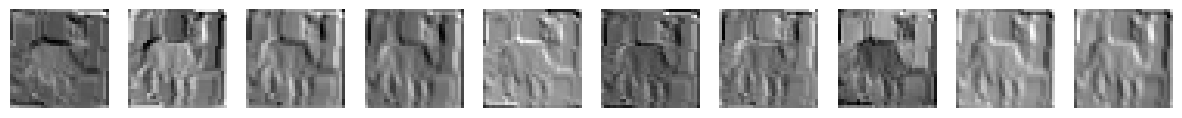

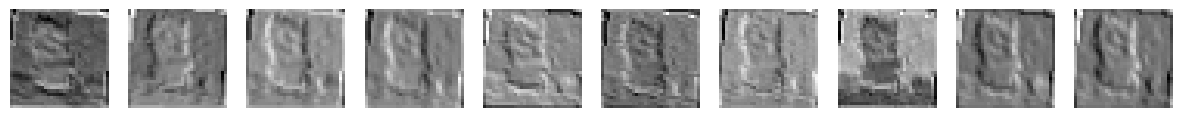

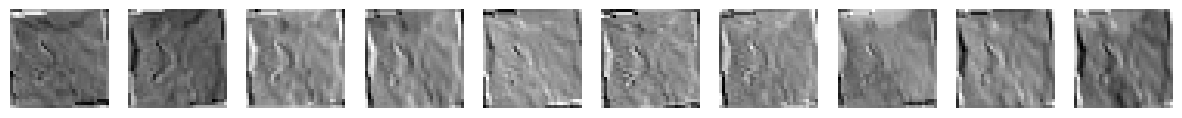

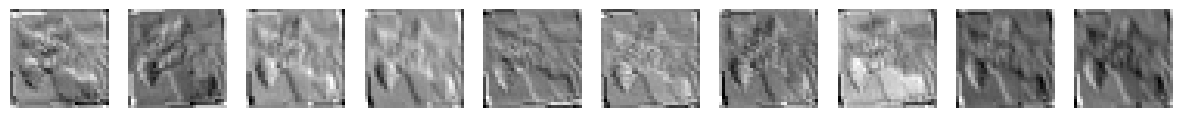

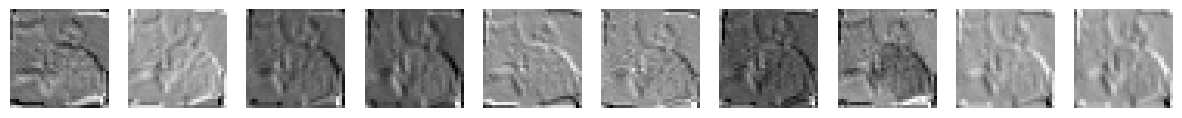

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def visualize_feature_maps(model, image_tensor, device):
    model.eval()
    # Access the first convolutional layer in the custom CNN
    layer = model.model[0]  # Accessing the first convolutional layer
    with torch.no_grad():
        feature_maps = layer(image_tensor.unsqueeze(0).to(device))
        feature_maps = feature_maps.squeeze(0).cpu().numpy()

    num_feature_maps = feature_maps.shape[0]
    # Limit the number of feature maps to plot for clarity
    num_to_plot = min(num_feature_maps, 10)
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 15))
    for i in range(num_to_plot):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

def visualize_dataset_feature_maps(dataset, model, device, num_images=5):
    for i in range(num_images):
        image, _ = dataset[i]  # Get image and label
        visualize_feature_maps(model, image, device)

# Example usage:
# Visualize feature maps for a subset of images from train and test datasets
visualize_dataset_feature_maps(train_dataset, model, device, num_images=5)
visualize_dataset_feature_maps(test_dataset, model, device, num_images=5)

alternate execution : densenet implementation

In [ ]:
import torch.nn as nn
from torchvision import models

class DenseNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(DenseNetBinaryClassifier, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.densenet(x)

model = DenseNetBinaryClassifier().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training the model

In [ ]:
import torch
import torch.optim as optim

# Initialize the model, criterion, and optimizer
model = DenseNetBinaryClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}")


# # Training loop with early stopping
# EPOCHS = 20
# best_val_loss = float('inf')
# early_stop_count = 0
# early_stop_patience = 3  # Stop if validation loss doesn't improve for 3 epochs

# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0
#     correct = 0
#     total = 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         preds = (outputs > 0.5).float()
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     train_accuracy = correct / total
#     print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}")

#     # Evaluate on validation set for early stopping
#     model.eval()
#     val_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:  # Use a separate validation set if possible
#             inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             preds = (outputs > 0.5).float()
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     val_accuracy = correct / total
#     print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         early_stop_count = 0
#     else:
#         early_stop_count += 1
#         if early_stop_count >= early_stop_patience:
#             print("Early stopping triggered.")
#             break

# # Final evaluation on test set
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
#         outputs = model(inputs)
#         preds = (outputs > 0.5).float()
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

# print(f"Test Accuracy: {correct/total:.4f}")

Epoch 1/10, Loss: 28.1585, Accuracy: 0.6907
Epoch 2/10, Loss: 22.5080, Accuracy: 0.7647
Epoch 3/10, Loss: 18.0815, Accuracy: 0.8293
Epoch 4/10, Loss: 20.2606, Accuracy: 0.8127
Epoch 5/10, Loss: 17.8969, Accuracy: 0.8327
Epoch 6/10, Loss: 14.9099, Accuracy: 0.8520
Epoch 7/10, Loss: 22.5891, Accuracy: 0.7667
Epoch 8/10, Loss: 24.7975, Accuracy: 0.7500
Epoch 9/10, Loss: 24.1003, Accuracy: 0.7433
Epoch 10/10, Loss: 21.0591, Accuracy: 0.7973


testing

In [ ]:
# Evaluate on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6960


evaluation metrics and visualization

Accuracy: 69.40%
Precision: 0.79
Recall: 0.53
F1 Score: 0.63
AUC: 0.79


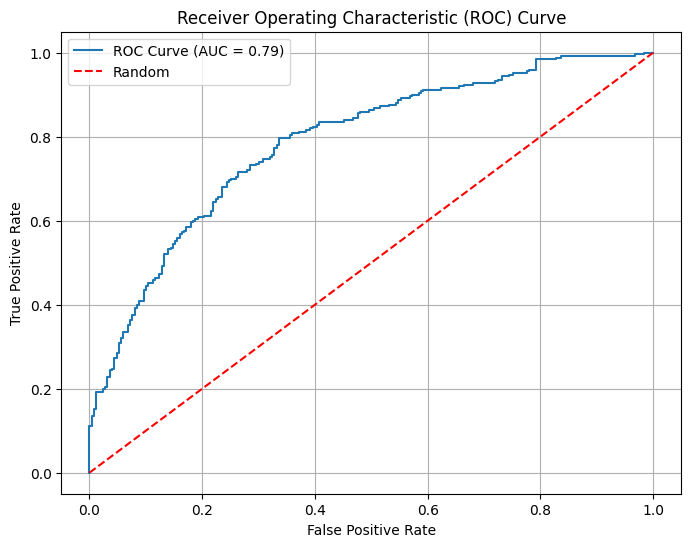

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

# Function to calculate precision, recall, F1 score, and AUC
def calculate_metrics(true_labels, predicted_labels):
    true_positive = np.sum((true_labels == 1) & (predicted_labels == 1))
    false_positive = np.sum((true_labels == 0) & (predicted_labels == 1))
    false_negative = np.sum((true_labels == 1) & (predicted_labels == 0))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate on the entire test set for more stable metrics
all_labels = []
all_preds = []
all_outputs = []  # Collect raw outputs for AUC calculation
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds.extend(preds.cpu().numpy().flatten())
        all_outputs.extend(outputs.cpu().numpy().flatten())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_preds))
    auc = roc_auc_score(np.array(all_labels), np.array(all_outputs))

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC: {auc:.2f}')

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(np.array(all_labels), np.array(all_outputs))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

feature maps visualization

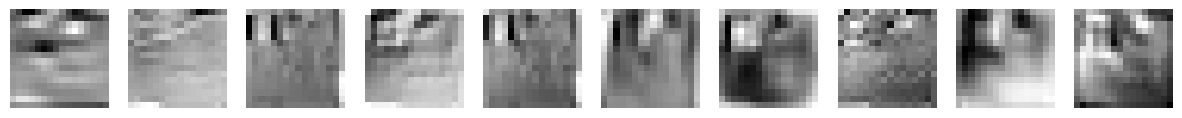

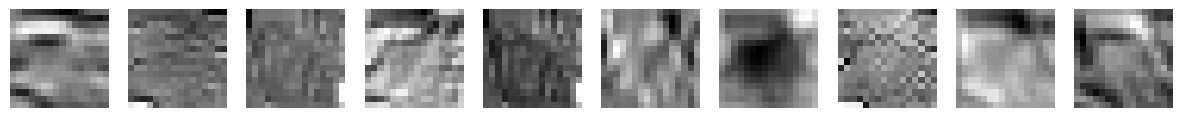

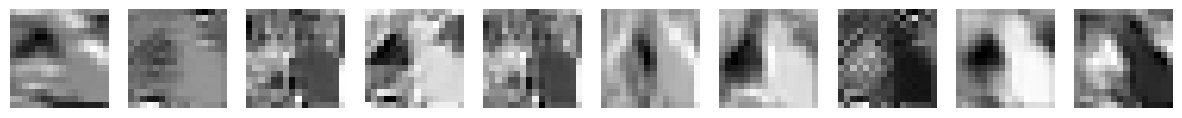

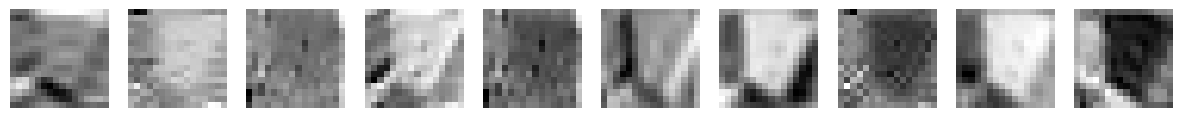

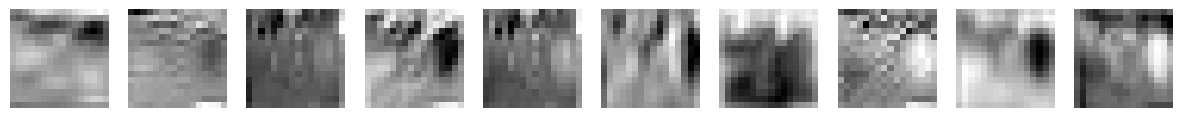

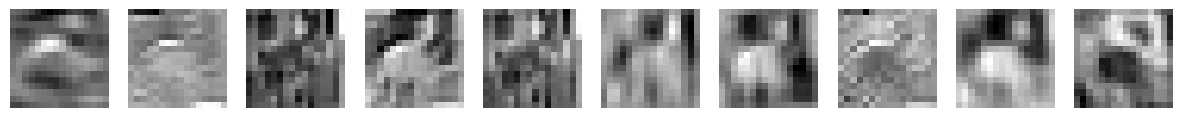

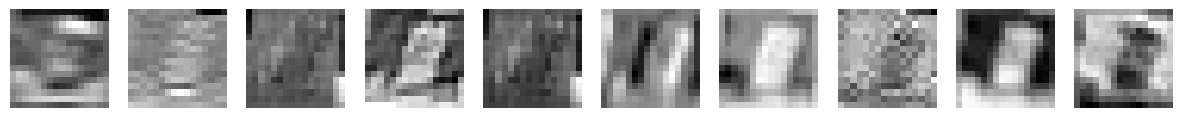

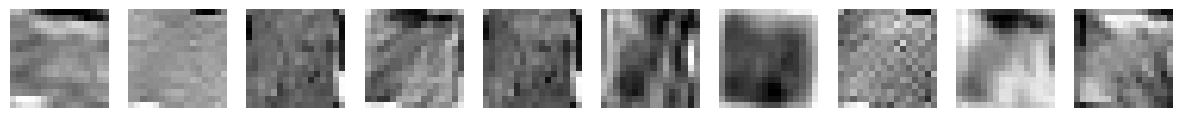

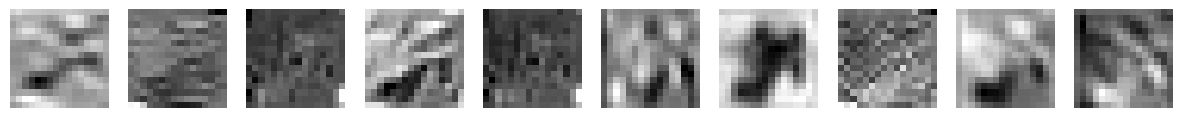

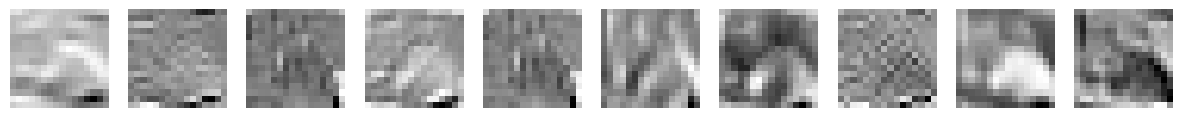

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def visualize_feature_maps(model, image_tensor, device):
    model.eval()
    # Access the first convolutional layer in DenseNet
    layer = model.densenet.features[0]  # Accessing the first convolutional layer
    with torch.no_grad():
        feature_maps = layer(image_tensor.unsqueeze(0).to(device))
        feature_maps = feature_maps.squeeze(0).cpu().numpy()

    num_feature_maps = feature_maps.shape[0]
    # Limit the number of feature maps to plot for clarity
    num_to_plot = min(num_feature_maps, 10)
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 15))
    for i in range(num_to_plot):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

def visualize_dataset_feature_maps(dataset, model, device, num_images=5):
    for i in range(num_images):
        image, _ = dataset[i]  # Get image and label
        visualize_feature_maps(model, image, device)

# Example usage:
# Visualize feature maps for a subset of images from train and test datasets
visualize_dataset_feature_maps(train_dataset, model, device, num_images=5)
visualize_dataset_feature_maps(test_dataset, model, device, num_images=5)